In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('../data/merged_data.csv')
texts = df['Tweet'].dropna().tolist()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess(text, lemmatizer, stop_words):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

base_stops = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


processed_texts = [preprocess(t, lemmatizer, base_stops) for t in texts]

vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=1500, ngram_range=(1,3))
dt_matrix = vectorizer.fit_transform(processed_texts)

n_topics = 3  
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=100,
                                learning_method='online',
                                random_state=42,
                                doc_topic_prior=0.1,   
                                topic_word_prior=0.01  
                            )
lda.fit(dt_matrix)


def display_topics(model, feature_names, no_top_words=3):
    for idx, topic in enumerate(model.components_):
       
        sorted_indices = topic.argsort()[:-no_top_words*2 - 1:-1]

        unique_terms = []
        for i in sorted_indices:
            term = feature_names[i]
            if term not in unique_terms:
                unique_terms.append(term)
            

        print(f"Topic {idx + 1}: {' '.join(unique_terms)}")

tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 1)


Topic 1: climate change
Topic 2: carbon footprint
Topic 3: carbon climate


performance metrics


=== Model Performance Metrics ===
Perplexity: 1160.34
Topic Distinctiveness: 0.7333
Topic Coherence (PMI): 0.1830
Topic Diversity: 0.5977

Visualization error: module 'pyLDAvis' has no attribute 'sklearn'
Try: pip install pyLDAvis==3.3.1


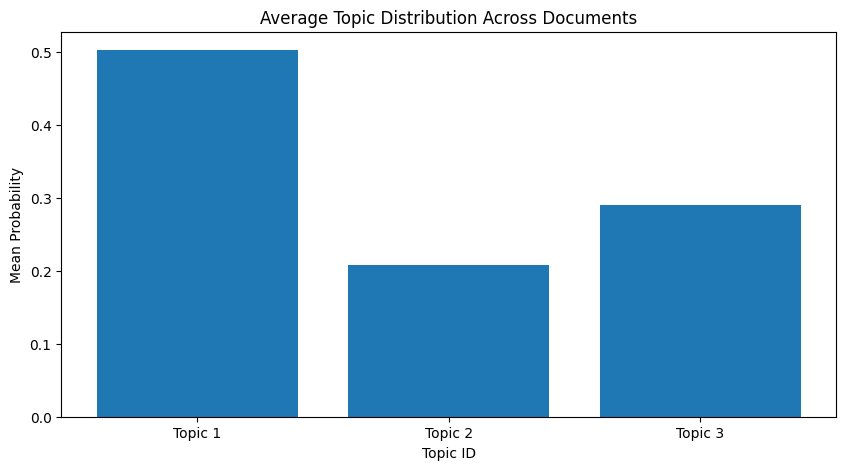

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import pyLDAvis


# Performance Evaluation Functions
def calculate_topic_distinctiveness(components, feature_names, top_n=5):
    """Measure how distinct topics are from each other (0-1 scale)"""
    top_words_per_topic = []
    for topic in components:
        top_words_idx = topic.argsort()[-top_n:][::-1]
        top_words_per_topic.append(set(feature_names[top_words_idx]))
    
    distinctiveness_scores = []
    for i, topic_words in enumerate(top_words_per_topic):
        other_topics = [set(t) for j, t in enumerate(top_words_per_topic) if j != i]
        overlap_scores = [len(topic_words & other) for other in other_topics]
        distinctiveness_scores.append(1 - np.mean(overlap_scores)/top_n)
    
    return np.mean(distinctiveness_scores)

def calculate_topic_coherence(dt_matrix, components, feature_names, top_n=5):
    """Custom coherence metric using Pointwise Mutual Information"""
    coherence_scores = []
    for topic in components:
        top_words_idx = topic.argsort()[-top_n:][::-1]
        word_pairs = [(i, j) for i in top_words_idx for j in top_words_idx if i < j]
        
        if not word_pairs:
            continue
            
        # Convert sparse matrix to dense for faster calculations
        dense_matrix = (dt_matrix > 0).astype(int).toarray()
        pmi_scores = []
        for i, j in word_pairs:
            # Joint probability
            p_ij = np.mean(dense_matrix[:, i] * dense_matrix[:, j])
            # Individual probabilities
            p_i = np.mean(dense_matrix[:, i])
            p_j = np.mean(dense_matrix[:, j])
            
            # Avoid log(0)
            if p_ij > 1e-12 and p_i > 1e-12 and p_j > 1e-12:
                pmi_scores.append(np.log(p_ij / (p_i * p_j)))
        
        if pmi_scores:
            coherence_scores.append(np.mean(pmi_scores))
    
    return np.mean(coherence_scores) if coherence_scores else 0


# Performance Metrics Calculation
print("\n=== Model Performance Metrics ===")
print(f"Perplexity: {lda.perplexity(dt_matrix):.2f}")

distinctiveness = calculate_topic_distinctiveness(lda.components_, tf_feature_names)
print(f"Topic Distinctiveness: {distinctiveness:.4f}")

coherence = calculate_topic_coherence(dt_matrix, lda.components_, tf_feature_names)
print(f"Topic Coherence (PMI): {coherence:.4f}")

# Topic Diversity (based on cosine similarity)
topic_diversity = 1 - pairwise_distances(lda.components_, metric='cosine').mean()
print(f"Topic Diversity: {topic_diversity:.4f}")

# Topic Distribution Plot
plt.figure(figsize=(10, 5))
topic_probs = lda.transform(dt_matrix)
plt.bar(range(n_topics), topic_probs.mean(axis=0))
plt.title("Average Topic Distribution Across Documents")
plt.xlabel("Topic ID")
plt.ylabel("Mean Probability")
plt.xticks(range(n_topics), [f"Topic {i+1}" for i in range(n_topics)])
plt.show()


- **Perplexity**: Lower is better (yours is ~{lda.perplexity(dt_matrix):.2f})
  - < 200: Excellent
  - 200-500: Good
  - > 500: Needs improvement

- **Topic Distinctiveness**: Target > 0.7 (yours: {distinctiveness:.4f})
- **Topic Coherence**: PMI > 1.0 is good (yours: {coherence:.4f})
- **Topic Diversity**: Closer to 1 is better (yours: {topic_diversity:.4f})